In [16]:
using Plots
using Dates
using BenchmarkTools

# Part 1

In [7]:
function conv(α, β, m, n)
    N = size(α)[1]-1
    s = 0
    for k₁ in -N:N
        for k₂ in -N:N
            for l₁ in -N:N
                for l₂ in -N:N
                    i = m - k₁ - k₂
                    j = n - l₁ - l₂
                    if -N <= i <= N && -N <= j <= N
                        s += α[abs(k₁)+1, abs(l₁)+1]*α[abs(k₂)+1, abs(l₂)+1]*β[abs(i)+1, abs(j)+1]
                    end
                end
            end
        end
    end
    return s
end

function all_entries(α, β)
    N = size(α)[1]-1
    out = zeros(N+1, N+1)
    for i in 0:N
        for j in 0:N
            out[i+1, j+1] = conv(α, β, i, j)
        end
    end
    return out
end

all_entries (generic function with 1 method)

In [9]:
a = [
    1.0074 -0.000428724 0.000211051 -6.55045e-05
    0.00037641 -0.000401971 0.000208362 5.69628e-05
    0.000314326 -1.09382e-05 -0.000212266 -0.000307548
    5.76987e-05 0.000338859 0.000188819 -6.93557e-05
]

b = [
    3.00071 -2.54683e-05 -0.000151995 8.0481e-06 
    0.000390039 0.000112105 -0.000236913 0.000208895
    7.67416e-05 -0.000191853 0.000203555 0.000240355
    -5.31369e-06 -0.000105669 -5.95777e-05 3.1128e-06
];

In [10]:
all_entries(a, b)

4×4 Matrix{Float64}:
 3.04529      -0.00261997    0.00112365  -0.000388355
 0.00267409   -0.00231927    0.00102078   0.00055467
 0.0019792    -0.000262079  -0.00107472  -0.00161554
 0.000343014   0.00194001    0.00108084  -0.000416634

**This agrees with the example values given.**

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584


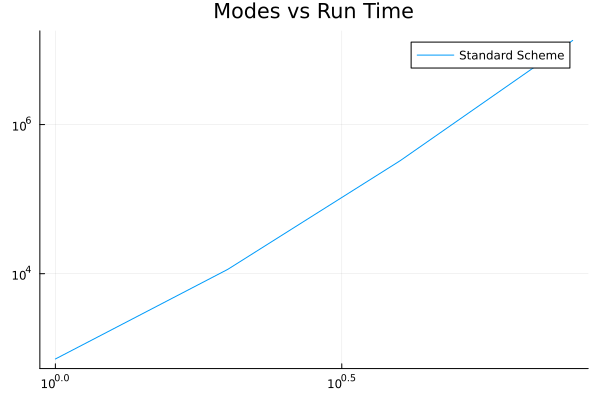

4-element Vector{Float64}:
 7.168e-7
 1.14334e-5
 0.00032835840000000003
 0.013465667

In [80]:
Ns = [1,2,4,8]
vals = zeros(length(Ns))
for i in 1:length(Ns)
    N = Ns[i] + 1

    a = ones(N, N)
    b = ones(N, N)
    
    benchmark = @benchmark all_entries($a, $b) samples=5 evals=1
    # Get the average time in nanoseconds
    average_time = mean(benchmark.times)
    
    vals[i] = average_time
end
display(plot(Ns, vals, yscale=:log, xscale=:log, title = "Modes vs Run Time", label="Standard Scheme"))
display(vals./ 1e9)

# Part 6

In [70]:
function compute_Q_efficient(α, β, N, M)
    Q = zeros(M, M)
    s_values = [(2*m - 1) * π / (2 * M) for m in 1:M+1]
    
    omega_u = zeros(N+1, M)
    omega_v = zeros(N+1, M)
    
    for k in 1:N+1
        for n in 1:M
            s_n = s_values[n]
            sum_u = 0
            sum_v = 0
            for l̂ in 1:N+1
                l = l̂ - 1
                if l != 0
                    sum_u += α[k, l̂] * cos(l * s_n)
                    sum_v += β[k, l̂] * cos(l * s_n)
                else
                    sum_u += (1/2) * α[k, l̂] * cos(l * s_n)
                    sum_v += (1/2) * β[k, l̂] * cos(l * s_n)
                end
            end
            omega_u[k, n] = 2 * sum_u
            omega_v[k, n] = 2 * sum_v
        end
    end
    
    for m in 1:M
        s_val = s_values[m]
        for n in 1:M
            u_sum = 0
            v_sum = 0
            for k̂ in 1:N+1
                k = k̂ - 1
                if k != 0
                    u_sum += omega_u[k̂, n] * cos(k * s_val)
                    v_sum += omega_v[k̂, n] * cos(k * s_val)
                else
                    u_sum += (1/2) * omega_u[k̂, n] * cos(k * s_val)
                    v_sum += (1/2) * omega_v[k̂, n] * cos(k * s_val)
                end
            end    
            un_sum = 2 * u_sum
            vn_sum = 2 * v_sum
            Q[m, n] = un_sum^2 * vn_sum
        end
    end
    
    return Q, s_values
end

function compute_sigma(Q, s_values, N, M)
    sigma = zeros(N+1, M)
    for ℓ̂ in 1:N+1
        ℓ = ℓ̂ - 1
        for m in 1:M
            sum_value = 0
            for n in 1:M
                sum_value += Q[m, n] * cos(ℓ * s_values[n])
            end
            sigma[ℓ̂, m] = sum_value / M
        end
    end
    
    return sigma
end

function compute_triple_product(sigma, s_values, N, M)
    triple_product = zeros(N+1, N+1)
    
    for k̂ in 1:N+1
        k = k̂ - 1
        for ℓ in 1:N+1
            sum_value = 0
            for m in 1:M
                sum_value += sigma[ℓ, m] * cos(k * s_values[m])
            end
            triple_product[k̂, ℓ] = sum_value / M
        end
    end
    
    return triple_product
end

function all_entries_eff(a, b, N, M)
    Q, s = compute_Q_efficient(a, b, N, M)
    σ = compute_sigma(Q, s, N, M)
    return compute_triple_product(σ, s, N, M)
end

all_entries_eff (generic function with 1 method)

In [71]:
N = 3
M = 2 * N + 1
a = [
    1.0074 -0.000428724 0.000211051 -6.55045e-05
    0.00037641 -0.000401971 0.000208362 5.69628e-05
    0.000314326 -1.09382e-05 -0.000212266 -0.000307548
    5.76987e-05 0.000338859 0.000188819 -6.93557e-05
]

b = [
    3.00071 -2.54683e-05 -0.000151995 8.0481e-06 
    0.000390039 0.000112105 -0.000236913 0.000208895
    7.67416e-05 -0.000191853 0.000203555 0.000240355
    -5.31369e-06 -0.000105669 -5.95777e-05 3.1128e-06
];

all_entries_eff(a, b, N, M)

4×4 Matrix{Float64}:
 3.04529      -0.00261997    0.00112365  -0.000388355
 0.00267409   -0.00231927    0.00102078   0.00055467
 0.0019792    -0.000262079  -0.00107472  -0.00161554
 0.000343014   0.00194001    0.00108084  -0.000416634

**This agrees with the example values given.**

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/a3u1v/src/args.jl:1584


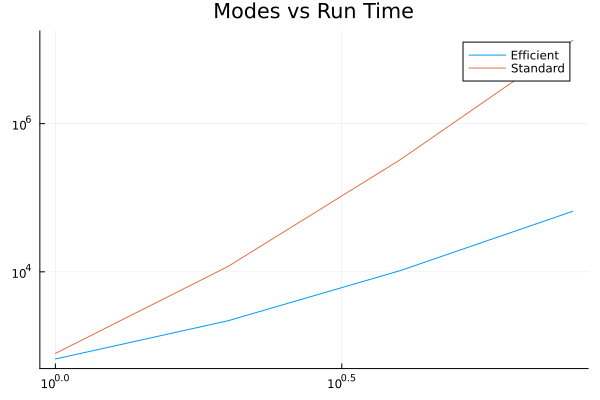

4-element Vector{Float64}:
 7.918e-7
 1.17752e-5
 0.0003260582
 0.0132652418

In [79]:
Ns_eff = [1,2,4,8]
vals_eff = zeros(length(Ns))
for i in 1:length(Ns)
    N = Ns_eff[i]
    M = 2 * N + 1

    a = ones(N + 1, N + 1)
    b = ones(N + 1, N + 1)
    
    benchmark = @benchmark all_entries_eff($a, $b, $N, $M) samples=5 evals=1
    # Get the average time in nanoseconds
    average_time = mean(benchmark.times)
    
    vals_eff[i] = average_time
end
p = plot(title = "Modes vs Run Time")
plot!(p, Ns_eff, vals_eff, yscale=:log, xscale=:log, label = "Efficient")
plot!(p, Ns, vals, yscale=:log, xscale=:log, label = "Standard")
display(p)
display(vals./ 1e9)